In [ ]:
import pandas as pd
import numpy as np
import requests
import calendar
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from datetime import datetime
from scipy.stats import norm
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import operator
import progressbar as pb
import statistics

In [ ]:
!pip install surprise

     |████████████████████████████████| 11.8 MB 4.1 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619420 sha256=012c0fea049f3eb7b55d0bfa7019fc57360c26c4fb2f20973312bed44d524b56
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
# Create Pandas Dataframe
books_df = pd.read_csv(r"/content/booksdf_project.csv")
books_df.head()

,book_id,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,publication_month,publication_day,publication_year
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,eng,652,2095690,27591,2006-09-16,Scholastic Inc.,September,Saturday,2006
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,eng,870,2153167,29221,2004-09-01,Scholastic Inc.,September,Wednesday,2004
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,eng,352,6333,244,2003-11-01,Scholastic,November,Saturday,2003
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,eng,435,2339585,36325,2004-05-01,Scholastic Inc.,May,Saturday,2004
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,eng,2690,41428,164,2004-09-13,Scholastic,September,Monday,2004


**<h2>EDA</h2>**

In [ ]:
#Books data set observations
book_count = books_df.shape[0]
ratings_on_books = books_df['ratings_count'].sum()
most_ratings = books_df.iloc[books_df['ratings_count'].idxmax()]
fewest_ratings = books_df.iloc[books_df['ratings_count'].idxmin()]

highest_average_rating = books_df.iloc[books_df['average_rating'].idxmax()]
lowest_average_rating = books_df.iloc[books_df['average_rating'].idxmin()]

print('Total number of books in dataset: %s' % "{:,}".format(book_count))
print('Total number of ratings on books in dataset: %s' % "{:,}".format(ratings_on_books))
print('Book with most ratings: %s with %s ratings' % (most_ratings['title'], "{:,}".format(most_ratings['ratings_count'])))
print('Book with fewest ratings: %s with %s ratings' % (fewest_ratings['title'], "{:,}".format(fewest_ratings['ratings_count'])))
print('Book with highest average rating: %s with %s average' % (highest_average_rating['title'], highest_average_rating['average_rating']))
print('Book with lowest average rating: %s with %s average' % (lowest_average_rating['title'], lowest_average_rating['average_rating']))

Total number of books in dataset: 10,000
Total number of ratings on books in dataset: 176,953,301
Book with most ratings: Twilight (Twilight  #1) with 4,597,666 ratings
Book with fewest ratings: Lonely Planet Londres with 0 ratings
Book with highest average rating: Comoediae 1: Acharenses/Equites/Nubes/Vespae/Pax/Aves with 5.0 average
Book with lowest average rating: Out to Eat London 2002 (Lonely Planet Out to Eat) with 0.0 average


In [ ]:
# Inspect datatypes
books_df.dtypes

book_id                 int64
title                  object
authors                object
average_rating        float64
language_code          object
num_pages               int64
ratings_count           int64
text_reviews_count      int64
publication_date       object
publisher              object
publication_month      object
publication_day        object
publication_year        int64
dtype: object

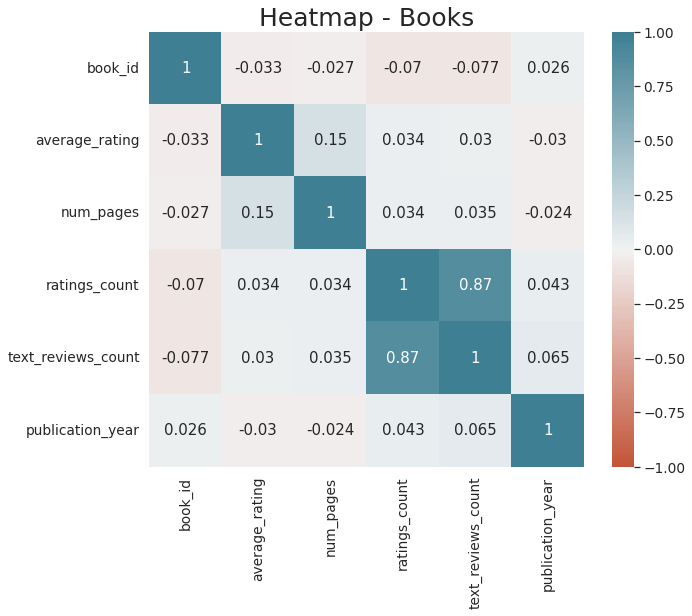

In [ ]:
# Correlation Matrix
plt.figure(figsize=(10,8))
sns.set(font_scale=1.25) 
corr_plt = sns.heatmap(
    books_df.corr(), 
    vmin = -1, 
    vmax = 1, 
    center = 0, 
    annot = True, 
    #cmap = 'mako',
    cmap=sns.diverging_palette(20, 220, n=200),
    square = True
)
corr_plt.axes.set_title("Heatmap - Books", fontsize=25)
plt.savefig('heatmap.png', bbox_inches="tight")

In [ ]:
# 50% of the books have less than 750 ratings, while 25% of books have more than 5000 ratings.
# Subsetting the dataset to include books only with 750+ ratings to avoid highly 
# skewed data.
print(books_df['ratings_count'].describe().apply(lambda x: format(x, 'f')))
books_ratings = books_df[books_df['ratings_count'] > 750]
books_ratings.shape

count      10000.000000
mean       17695.330100
std       112914.548735
min            0.000000
25%          104.000000
50%          752.500000
75%         5019.000000
max      4597666.000000
Name: ratings_count, dtype: object


(5004, 13)

[Text(0, 0, '0K'),
 Text(0, 0, '100K'),
 Text(0, 0, '200K'),
 Text(0, 0, '300K'),
 Text(0, 0, '400K'),
 Text(0, 0, '500K')]

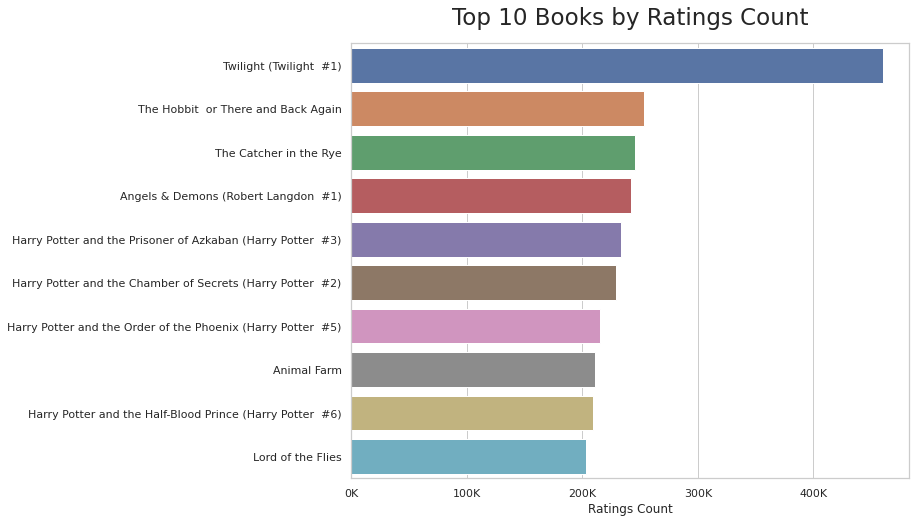

In [ ]:
# Top 10 Books by Rating Count
plt.figure(figsize=(10,8))
top10_ratings_count = books_ratings.sort_values(by='ratings_count', ascending=False).head(10)
sns.set(font_scale=1.25)
sns.set(style='whitegrid', palette="deep")
bar_plt = sns.barplot(x = top10_ratings_count['ratings_count'], y = top10_ratings_count['title'])
bar_plt.set(ylabel=None)
bar_plt.set(xlabel="Ratings Count")
bar_plt.axes.set_title("Top 10 Books by Ratings Count", fontsize=23, y=1.03)
xlabels = ['{:,.0f}'.format(x) + 'K' for x in bar_plt.get_xticks()/10000]
bar_plt.set_xticklabels(xlabels)

Text(0.5, 1.03, 'Top 10 Books by Average Rating')

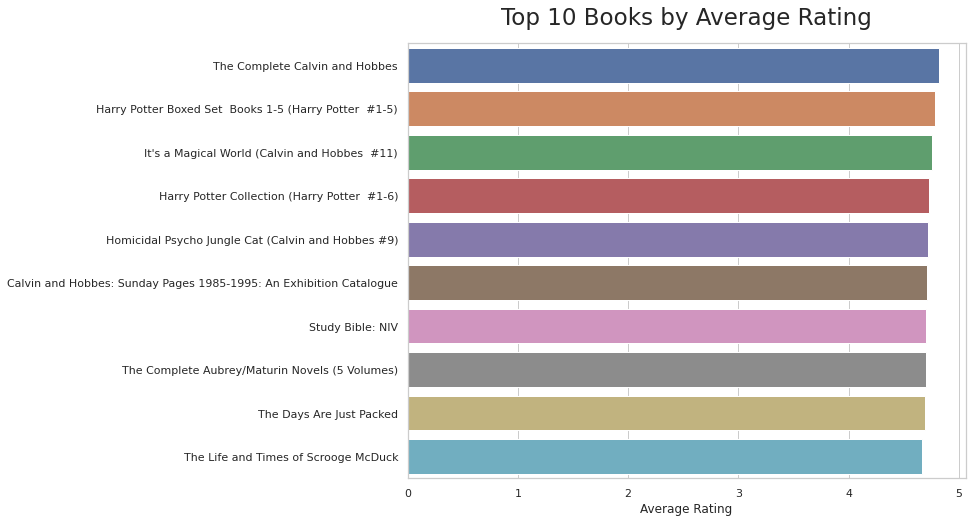

In [ ]:
# Top 10 Books by Average Rating
top10_avg_rating = books_df[books_df['ratings_count'] > 750]
top10_avg_rating = top10_avg_rating.sort_values('average_rating', ascending=False).head(10)
plt.figure(figsize=(10,8))
sns.set(font_scale=1.25)
sns.set(style='whitegrid', palette="deep")
bar_plt = sns.barplot(x = top10_avg_rating['average_rating'], y = top10_avg_rating['title'])
bar_plt.set(ylabel=None)
bar_plt.set(xlabel="Average Rating")
bar_plt.axes.set_title("Top 10 Books by Average Rating", fontsize=23, y=1.03)

[Text(0, 0, 'eng'),
 Text(0, 0, 'en-US'),
 Text(0, 0, 'en-GB'),
 Text(0, 0, 'spa'),
 Text(0, 0, 'fre'),
 Text(0, 0, 'ger'),
 Text(0, 0, 'jpn'),
 Text(0, 0, 'mul'),
 Text(0, 0, 'zho'),
 Text(0, 0, 'grc'),
 Text(0, 0, 'por'),
 Text(0, 0, 'en-CA'),
 Text(0, 0, 'ita'),
 Text(0, 0, 'lat'),
 Text(0, 0, 'enm'),
 Text(0, 0, 'swe'),
 Text(0, 0, 'rus'),
 Text(0, 0, 'nl'),
 Text(0, 0, 'msa'),
 Text(0, 0, 'nor'),
 Text(0, 0, 'tur'),
 Text(0, 0, 'wel'),
 Text(0, 0, 'glg'),
 Text(0, 0, 'ale'),
 Text(0, 0, 'gla'),
 Text(0, 0, 'ara')]

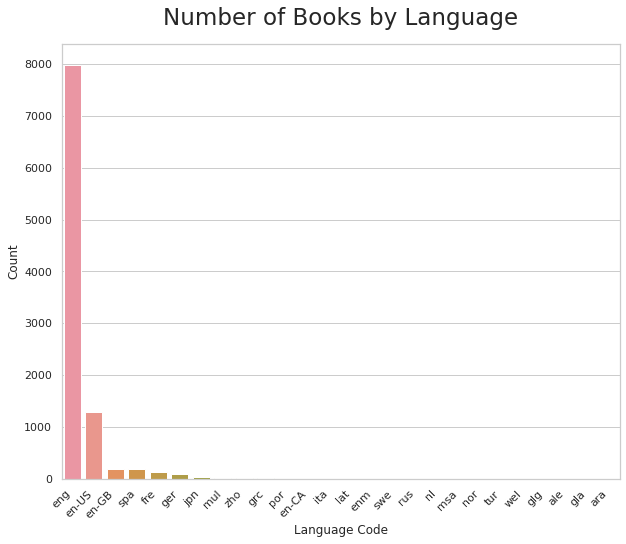

In [ ]:
# Barplot number of books by language
language_counts = pd.DataFrame(books_df['language_code'].value_counts()).reset_index()
language_counts.columns = ['lang_code', 'count']
plt.figure(figsize=(10,8))
sns.set(style='whitegrid', palette="deep")
bar_plt = sns.barplot(x = language_counts['lang_code'], y = language_counts['count'])
bar_plt.set(ylabel="Count")
bar_plt.set(xlabel="Language Code")
bar_plt.axes.set_title("Number of Books by Language", fontsize=23, y=1.03)
bar_plt.set_xticklabels(bar_plt.get_xticklabels(), rotation=45, horizontalalignment='right')

Text(0.5, 1.03, 'Number of Books by Publication Year')

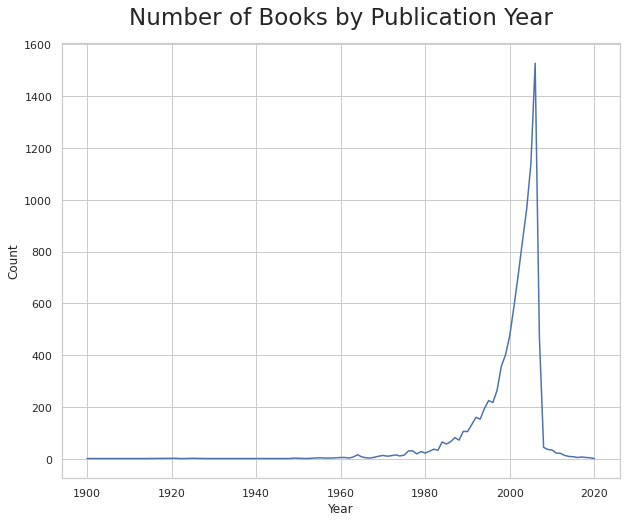

In [ ]:
# Lineplots books by year, month, day
year_counts = pd.DataFrame(books_df['publication_year'].value_counts()).reset_index()
year_counts.columns = ['year', 'count']
plt.figure(figsize=(10,8))
sns.set(style='whitegrid', palette="deep")
line_plt = sns.lineplot(x = year_counts['year'], y = year_counts['count'])
line_plt.set(ylabel="Count")
line_plt.set(xlabel="Year")
line_plt.axes.set_title("Number of Books by Publication Year", fontsize=23, y=1.03)
#line_plt.set_xticklabels(line_plt.get_xticklabels(), rotation=90, horizontalalignment='right')

In [ ]:
# Ratings
ratings_df = pd.read_csv("/content/Ratings.csv")
ratings_df.head()
len(ratings_df)

1048575

In [ ]:
#Raitings data set observations

rating_count = ratings_df.shape[0]
percent_of_total = (rating_count / ratings_on_books) * 100

mean_rating = ratings_df['rating'].mean()
median_rating = ratings_df['rating'].median()

user_count = ratings_df['user_id'].nunique()
ratings_per_user = rating_count / user_count

print('Total number of ratings in dataset: %s' % "{:,}".format(rating_count))
print('Percent of total ratings included in this dataset: %s percent' % round(percent_of_total, 2))
print('Mean rating: %s' % round(mean_rating, 2))
print('Median rating: %s' % median_rating)
print('Total number of users in dataset: %s' % "{:,}".format(user_count))
print('Ratings per user: %s' % round(ratings_per_user, 2))

Total number of ratings in dataset: 1,048,575
Percent of total ratings included in this dataset: 0.59 percent
Mean rating: 3.81
Median rating: 4.0
Total number of users in dataset: 13,123
Ratings per user: 79.9


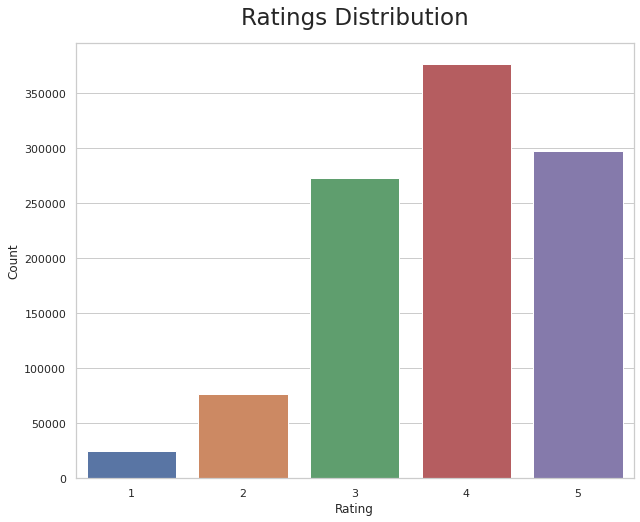

In [ ]:
# Ratings Distribution
language_counts = pd.DataFrame(books_df['language_code'].value_counts()).reset_index()
language_counts.columns = ['lang_code', 'count']
plt.figure(figsize=(10,8))
sns.set(style='whitegrid', palette="deep")
cnt_plt = sns.countplot(x ='rating', data = ratings_df)
cnt_plt.set(ylabel="Count")
cnt_plt.set(xlabel="Rating")
cnt_plt.axes.set_title("Ratings Distribution", fontsize=23, y=1.03)
cnt_plt.ticklabel_format(style='plain', axis='y')

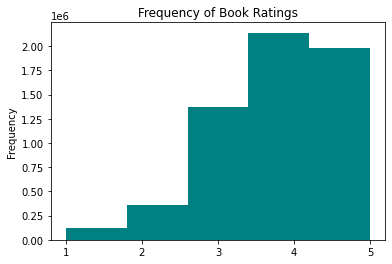

In [ ]:
# Create a histogram of the ratings
ratings_df['rating'].plot(kind='hist', bins=5, xticks=[1,2,3,4,5], title='Frequency of Book Ratings', color = "teal")

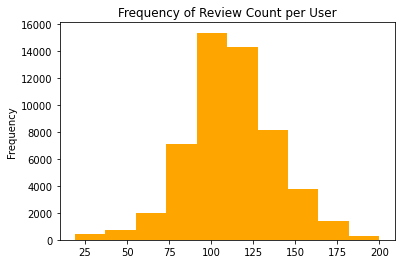

In [ ]:
# Create a histogram of rating count per user
ratings_df['user_id'].value_counts().plot(kind='hist', title='Frequency of Review Count per User', color = "orange")

In [ ]:
#AuthorsAndBookCounts
books_df.authors.value_counts()

Stephen King                                           38
Rumiko Takahashi                                       37
P.G. Wodehouse                                         34
Orson Scott Card                                       31
Agatha Christie                                        30
                                                       ..
Daniel Abraham                                          1
C.E. Murphy                                             1
Joseph Conrad/Morton Dauwen Zabel/Frederick R. Karl     1
Steve Perry/Michael Reaves                              1
Ben Schott/Collin Deckerman                             1
Name: authors, Length: 6108, dtype: int64

In [ ]:
# Combine book and ratings data
ratings_books_df = pd.merge(ratings_df, books_df, on='book_id')
columns_to_remove = ['authors', 
                  'average_rating', 
                  'language_code',
                  'num_pages',
                  'ratings_count',
                  'text_reviews_count',
                  'publication_date',
                  'publisher',
                  'publication_month',
                  'publication_day',
                  'publication_year']
ratings_books_df = ratings_books_df.drop(columns_to_remove, axis=1)
ratings_books_df.head()

,user_id,book_id,rating,title
0,2,26,4,The Lost Continent: Travels in Small Town America
1,4,26,3,The Lost Continent: Travels in Small Town America
2,9,26,2,The Lost Continent: Travels in Small Town America
3,11,26,3,The Lost Continent: Travels in Small Town America
4,15,26,3,The Lost Continent: Travels in Small Town America


In [ ]:
# Group by title and add a column to represent count of ratings for each book
ratings_books_df = ratings_books_df.dropna(axis=0, subset=['title'])
ratings_count_df = ratings_books_df.groupby(by = ['title'])['rating'].count().reset_index()
ratings_count_df.head()

# Combine ratings_count_df and ratings_books_df to filter out less
# reviewed books
ratings_total_count_df = ratings_books_df.merge(ratings_count_df, left_on='title', right_on='title', how='left')
ratings_total_count_df.columns = ['user_id', 'book_id', 'rating', 'title', 'total_ratings']
ratings_total_count_df.head()

,user_id,book_id,rating,title,total_ratings
0,2,26,4,The Lost Continent: Travels in Small Town America,4725
1,4,26,3,The Lost Continent: Travels in Small Town America,4725
2,9,26,2,The Lost Continent: Travels in Small Town America,4725
3,11,26,3,The Lost Continent: Travels in Small Town America,4725
4,15,26,3,The Lost Continent: Travels in Small Town America,4725


In [ ]:
# Check the descriptive statistics of total ratings to see how the 
# total reviews are distributed and if we should subset the data for building
# out model
ratings_total_count_df['total_ratings'].describe()

# There is a book the has only one review, 25% of books have less than 340 reviews
# Our model won't be accurate if we include data with low review counts.
# To make sure we get results that make sense I think we should limit our dataset
# to include books with more that 340 reviews.
most_pop_books_df = ratings_total_count_df[ratings_total_count_df['total_ratings'] > 340]
print(f"Original dataset: {ratings_total_count_df.shape}")
print(f"New dataset: {most_pop_books_df.shape}")
most_pop_books_df.head()

Original dataset: (353374, 5)
New dataset: (246463, 5)


,user_id,book_id,rating,title,total_ratings
0,2,26,4,The Lost Continent: Travels in Small Town America,4725
1,4,26,3,The Lost Continent: Travels in Small Town America,4725
2,9,26,2,The Lost Continent: Travels in Small Town America,4725
3,11,26,3,The Lost Continent: Travels in Small Town America,4725
4,15,26,3,The Lost Continent: Travels in Small Town America,4725


In [ ]:
# Group the ratings by book and merge books_df to add book titles for easy identification
df = pd.DataFrame(ratings_df.groupby('book_id')['rating'].mean()).reset_index()
df['rating_count'] = pd.DataFrame(ratings_df.groupby('book_id')['rating'].count())

# We can see that books with the most ratings also have a fairly high average user rating.
# I think this will allow for correlation to make decent recommendation
print(df.sort_values('rating_count', ascending=False).head(10))

# Pivot to create a 2d matrix of users and their book ratings
df_pivot = ratings_df.pivot_table(index='user_id', columns='book_id').rating
user_id = df_pivot.index
book_id = df_pivot.columns

# Data in the 2D matrix is sparse because not every user rated every book
print(df_pivot.head())

    book_id    rating  rating_count
2         3  3.428427        4937.0
26       27  4.349310        4725.0
4         5  3.690201        4651.0
18       19  4.162694        4335.0
23       24  4.300649        4329.0
24       25  4.437710        4314.0
21       22  3.513233        4203.0
25       26  3.423069        4158.0
27       28  3.617868        4131.0
5         6  4.600000        3980.0
book_id  1      2      3      4      5      ...  9996   9997   9998   9999   10000
user_id                                     ...                                   
1          NaN    NaN    NaN    5.0    NaN  ...    NaN    NaN    NaN    NaN    NaN
2          NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN
3          NaN    NaN    NaN    3.0    NaN  ...    NaN    NaN    NaN    NaN    NaN
4          NaN    5.0    NaN    4.0    4.0  ...    NaN    NaN    NaN    NaN    NaN
6          NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN

[5 rows x 7774 columns

In [ ]:
books_df[books_df['title'] == 'The Iliad']

,book_id,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,publication_month,publication_day,publication_year
356,1371,The Iliad,Homer/Robert Fagles/Bernard Knox,3.86,eng,683,288792,3423,1999-04-29,Penguin Classics,April,Thursday,1999
358,1374,The Iliad,Homer/Robert Fitzgerald/Andrew Ford,3.86,en-US,588,692,81,2004-04-03,Farrar Straus and Giroux,April,Saturday,2004
360,1376,The Iliad,Homer/E.V. Rieu/Peter Jones/D.C.H. Rieu,3.86,eng,462,1919,118,2003-01-30,Penguin Classics,January,Thursday,2003
361,1377,The Iliad,Homer/W.H.D. Rouse,3.86,en-US,312,158,15,1999-08-01,Signet Classics,August,Sunday,1999
493,1796,The Iliad,Homer/Robert Fitzgerald,3.86,eng,594,30,2,1992-03-19,Everyman,March,Thursday,1992
3010,12254,The Iliad,Homer/Robert Fagles/Derek Jacobi,3.86,eng,8,42,7,2006-06-15,Penguin-HighBridge,June,Thursday,2006
5327,22221,The Iliad,Homer,3.86,eng,150,3834,134,1999-10-28,John Wiley & Sons,October,Thursday,1999
7673,32780,The Iliad,Homer/Andrew Lang,3.86,eng,542,64,8,2011-09-01,Collector's Library,September,Thursday,2011
7675,32782,The Iliad,Homer/Victor G. Ambrus/Nick McCarty,3.86,eng,95,8,3,2000-09-15,Kingfisher,September,Friday,2000


**<h3>Model 1 - Correlation Recommendation System</h3>**

In [ ]:
# We can test 3 books to see how well correlation works

# book_id = 1371 - The Iliad
test1_df = df_pivot[1371]
rec_test1 = df_pivot.corrwith(test1_df)
corr_df = pd.DataFrame(rec_test1, columns=['Correlation'])
corr_df.dropna(inplace=True)
corr_df = pd.merge(corr_df, books_df, on='book_id')
corr_df = corr_df[['book_id', 'Correlation', 'title']]
corr_df.sort_values('Correlation', ascending=False).head(10)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,book_id,Correlation,title
213,1853,1.0,Wild About Books
161,966,1.0,Angeles & Demonios
235,2680,1.0,Empire 2.0: A Modest Proposal for a United Sta...
250,3978,1.0,A Winter Haunting (Seasons of Horror #2)
185,1371,1.0,The Iliad
73,157,1.0,Anna Karenina
170,1068,1.0,1776
215,1902,1.0,In the Land of White Death: An Epic Story of S...
223,2136,1.0,Specimen Days
150,828,1.0,Interface


In [ ]:
# book_id = 23 - Bryson's Dictionary of Troublesome Words
test1_df = df_pivot[23]
rec_test1 = df_pivot.corrwith(test1_df)
corr_df = pd.DataFrame(rec_test1, columns=['Correlation'])
corr_df.dropna(inplace=True)
corr_df = pd.merge(corr_df, books_df, on='book_id')
corr_df = corr_df[['book_id', 'Correlation', 'title']]
corr_df.sort_values('Correlation', ascending=False).head(10)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,book_id,Correlation,title
476,3042,1.0,Knowledge And Decisions
405,2375,1.0,The Bone Collector's Son
923,7842,1.0,Another Day in Cubicle Paradise
935,8012,1.0,Mr. Impossible
908,7721,1.0,The Metamorphosis
741,5527,1.0,All the King's Men
1001,9143,1.0,Ballet Class
303,1595,1.0,Genres in Dialogue: Plato and the Construct of...
304,1618,1.0,The Curious Incident of the Dog in the Night-Time
661,4898,1.0,Blue Ocean Strategy: How to Create Uncontested...


In [ ]:
# book_id = 4 - Harry Potter and the Chamber of Secrets
test1_df = df_pivot[4]
rec_test1 = df_pivot.corrwith(test1_df)
corr_df = pd.DataFrame(rec_test1, columns=['Correlation'])
corr_df.dropna(inplace=True)
corr_df = pd.merge(corr_df, books_df, on='book_id')
corr_df = corr_df[['book_id', 'Correlation', 'title']]
corr_df.sort_values('Correlation', ascending=False).head(10)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,book_id,Correlation,title
757,5898,1.0,The Lord of the Rings (The Lord of the Rings ...
956,8891,1.0,Return to the Planet of the Apes: Visions fro...
437,2706,1.0,Love Visions
318,1721,1.0,Ovid’s Metamorphoses: Books 6-10
660,4940,1.0,The Brothers Karamazov
834,7006,1.0,Hamlet
615,4399,1.0,The Grapes of Wrath
540,3604,1.0,Personal Finance for Dummies
909,7996,1.0,Redwall (Redwall #1)
941,8694,1.0,Life the Universe and Everything (Hitchhiker'...


**<h3>Model 2 - KNN - Collaborative Filtering (Item-based)</h3>**

In [ ]:
# Use sklearn to create a scipy matrix to make knn more efficient
knn_pivot_table = most_pop_books_df.pivot_table(index='title', columns='user_id', values='rating').fillna(0)
knn_matrix = csr_matrix(knn_pivot_table.values)

In [ ]:
# Create a KNN unsupervised classification model using the 
# brute algorithm and fit our model
books_knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
books_knn_model.fit(knn_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [ ]:
knn_pivot_table.index[139:150]

Index(['The Iliad', 'The Kingdom of God Is Within You', 'The Known World',
       'The Long Dark Tea-Time of the Soul (Dirk Gently  #2)',
       'The Long Shadow (The Morland Dynasty  #6)',
       'The Lord of the Rings (The Lord of the Rings  #1-3)',
       'The Lord of the Rings: Complete Visual Companion',
       'The Lord of the Rings: The Art of the Fellowship of the Ring',
       'The Lord of the Rings: Weapons and Warfare',
       'The Lost Continent: Travels in Small Town America',
       'The Mother Tongue: English and How It Got That Way'],
      dtype='object', name='title')

In [ ]:
# Test KNN model
#test_book_index = np.random.choice(knn_pivot_table.shape[0])
test_book_index = 139
##print(f"Test book id: {test_book_index}")
distances, indices = books_knn_model.kneighbors(knn_pivot_table.iloc[test_book_index, :].values.reshape(1, -1), n_neighbors = 6)

# Check out the recommendations
for i in range(0, len(distances.flatten())):
  if i == 0:
    print(f"Recommendations for {knn_pivot_table.index[test_book_index]}")
  else:
    print(f"{i}: {knn_pivot_table.index[indices.flatten()[i]]}, with distance {distances.flatten()[i]}")

Recommendations for The Iliad
1: Great Jones Street, with distance 0.8844422580203157
2: The Kingdom of God Is Within You, with distance 0.8857918369127253
3: Agile Web Development with Rails: A Pragmatic Guide, with distance 0.8860570834204622
4: The Lord of the Rings (The Lord of the Rings  #1-3), with distance 0.8883419447696739
5: Simply Beautiful Beading: 53 Quick and Easy Projects, with distance 0.8933857518508036


**<h3>Model 3 - KNN - Collaborative Filtering (User-based)</h3>**

In [ ]:
# avg number of ratings given per book
ratings_per_book = ratings_df.groupby('book_id')['rating'].count()
statistics.mean(ratings_per_book.tolist())

134.88229997427322

In [ ]:
# avg number of ratings given per user
ratings_per_user = ratings_df.groupby('user_id')['rating'].count()
statistics.mean(ratings_per_user.tolist())

79.90360435875942

In [ ]:
# counts of ratings per book as a df
ratings_per_book_df = pd.DataFrame(ratings_per_book)

# remove if < 1000 ratings
filtered_ratings_per_book_df = ratings_per_book_df[ratings_per_book_df.rating >= 1000]
# build a list of book_ids to keep
popular_books = filtered_ratings_per_book_df.index.tolist()

In [ ]:
# counts ratings per user as a df
ratings_per_user_df = pd.DataFrame(ratings_per_user)
# remove if < 25
filtered_ratings_per_user_df = ratings_per_user_df[ratings_per_user_df.rating >= 50]
# build a list of user_ids to keep
top_users = filtered_ratings_per_user_df.index.tolist()

In [ ]:
# filter ratings by top users and most rated books
filtered_ratings = ratings_df[ratings_df.book_id.isin(popular_books)]
filtered_ratings = ratings_df[ratings_df.user_id.isin(top_users)]
len(filtered_ratings)

956196

In [ ]:
# Create a rating matrix between users and books
rating_matrix = filtered_ratings.pivot_table(index='user_id', columns='book_id', values='rating')
# replace NaN values with 0
rating_matrix = rating_matrix.fillna(0)
# display the top few rows
rating_matrix.head()

book_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,9946,9948,9949,9951,9956,9957,9958,9960,9961,9962,9963,9965,9966,9967,9968,9972,9973,9974,9975,9976,9977,9978,9979,9980,9981,9984,9985,9986,9987,9988,9990,9991,9993,9994,9995,9996,9997,9998,9999,10000
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,0.0,4.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,0.0,5.0,4.0,0.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,5.0,0.0,4.0,4.0,0.0,4.0,4.0,0.0,5.0,4.0,0.0,4.0,3.0,0.0,0.0,0.0,5.0,2.0,0.0,5.0,1.0,5.0,5.0,5.0,3.0,5.0,3.0,0.0,0.0,0.0,4.0,3.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Function returns similar users using knn cosine similarity algorithm
def similar_users(user_id, matrix, k=3):
    # create a user dataframes for comparison
    user = matrix[matrix.index == user_id]
    other_users = matrix[matrix.index != user_id]
    
    # calculate cosine similarity between user and each other user
    similarities = cosine_similarity(user,other_users)[0].tolist()
    
    indices = other_users.index.tolist()
    
    # key/values pairs of user index and their similarity
    index_similarity = dict(zip(indices, similarities))
    
    # sort by similarity
    index_similarity_sorted = sorted(index_similarity.items(), key=operator.itemgetter(1))
    index_similarity_sorted.reverse()
    
    # grab k users off the top
    top_users_similarities = index_similarity_sorted[:k]
    users = [u[0] for u in top_users_similarities]
    
    return users

In [ ]:
# Test similar users
current_user = 1

# try out a user
similar_user_indices = similar_users(current_user, rating_matrix)

print(similar_user_indices)

[12490, 13746, 3987]


In [ ]:
# function that returns recommended books based on similar users
def recommend_book(user_index, similar_user_indices, matrix, items=5):
    
    # load vectors for similar users
    similar_users = matrix[matrix.index.isin(similar_user_indices)]
    # calc avg ratings across the 3 similar users
    similar_users = similar_users.mean(axis=0)
    # convert to dataframe so its easy to sort and filter
    similar_users_df = pd.DataFrame(similar_users, columns=['mean'])
    
    
    # load vector for the current user
    user_df = matrix[matrix.index == user_index]
    # transpose it so its easier to filter
    user_df_transposed = user_df.transpose()
    # rename the column as 'rating'
    user_df_transposed.columns = ['rating']
    # remove any rows without a 0 value. Anime not watched yet
    user_df_transposed = user_df_transposed[user_df_transposed['rating']==0]
    # generate a list of animes the user has not seen
    books_unseen = user_df_transposed.index.tolist()
    
    # filter avg ratings of similar users for only anime the current user has not seen
    similar_users_df_filtered = similar_users_df[similar_users_df.index.isin(books_unseen)]
    # order the dataframe
    similar_users_df_ordered = similar_users_df.sort_values(by=['mean'], ascending=False)
    # grab the top n anime   
    top_n_books = similar_users_df_ordered.head(items)
    top_n_books_indices = top_n_books.index.tolist()
    # lookup these anime in the other dataframe to find names
    book_information = books_df[books_df['book_id'].isin(top_n_books_indices)]
    
    return book_information

In [ ]:
# Test user-based recommender
df = recommend_book(1, similar_user_indices, rating_matrix)
df[['book_id', 'title', 'ratings_count']]

,book_id,title,ratings_count
23,35,The Lord of the Rings (The Lord of the Rings ...,1618
26,45,Agile Web Development with Rails: A Pragmatic ...,1430
59,103,God Emperor of Dune (Dune Chronicles #4),2785


**<h3>Model 4 - Content Based Filtering</h3>**



In [ ]:
tfidf = TfidfVectorizer(stop_words='english')
# Construct the required TF-IDF matrix by applying the fit_transform method on the overview feature
overview_matrix = tfidf.fit_transform(books_df['title'])
# Output the shape of tfidf_matrix
overview_matrix.shape

(10000, 10436)

In [ ]:
similarity_matrix = linear_kernel(overview_matrix,overview_matrix)
similarity_matrix

array([[1.        , 0.71072106, 0.71191747, ..., 0.        , 0.        ,
        0.        ],
       [0.71072106, 1.        , 0.72929155, ..., 0.        , 0.        ,
        0.        ],
       [0.71191747, 0.72929155, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [ ]:
# movies index mapping
mapping = pd.Series(books_df.index,index = books_df['title'])
mapping

title
Harry Potter and the Half-Blood Prince (Harry Potter  #6)          0
Harry Potter and the Order of the Phoenix (Harry Potter  #5)       1
Harry Potter and the Chamber of Secrets (Harry Potter  #2)         2
Harry Potter and the Prisoner of Azkaban (Harry Potter  #3)        3
Harry Potter Boxed Set  Books 1-5 (Harry Potter  #1-5)             4
                                                                ... 
Expelled from Eden: A William T. Vollmann Reader                9995
You Bright and Risen Angels                                     9996
The Ice-Shirt (Seven Dreams #1)                                 9997
Poor People                                                     9998
Las aventuras de Tom Sawyer                                     9999
Length: 10000, dtype: int64

In [ ]:
# Function to recommend books based on cosine-similarity
def recommend_books_based_on_title(book_input):
  book_index = mapping[book_input]

  #get similarity values with other books
  #similarity_score is the list of index and similarity matrix
  similarity_score = list(enumerate(similarity_matrix[book_index]))

  #sort in descending order the similarity score of book inputted with all the other books
  similarity_score = sorted(similarity_score, key=lambda x: x[1].any(), reverse=True)

  # Get the scores of the 15 most similar books. Ignore the first book.
  similarity_score = similarity_score[1:15]

  #return movie names using the mapping series
  book_indices = [i[0] for i in similarity_score]
  return (books_df['title'].iloc[book_indices])

In [ ]:
recommend_books_based_on_title('The Iliad')

1    Harry Potter and the Order of the Phoenix (Har...
2    Harry Potter and the Chamber of Secrets (Harry...
3    Harry Potter and the Prisoner of Azkaban (Harr...
4    Harry Potter Boxed Set  Books 1-5 (Harry Potte...
5    Unauthorized Harry Potter Book Seven News: "Ha...
6         Harry Potter Collection (Harry Potter  #1-6)
7    The Ultimate Hitchhiker's Guide: Five Complete...
8    The Ultimate Hitchhiker's Guide to the Galaxy ...
Name: title, dtype: object

In [ ]:
recommend_books_based_on_title('Treasure Island')

1    Harry Potter and the Order of the Phoenix (Har...
2    Harry Potter and the Chamber of Secrets (Harry...
3    Harry Potter and the Prisoner of Azkaban (Harr...
4    Harry Potter Boxed Set  Books 1-5 (Harry Potte...
Name: title, dtype: object

In [ ]:
recommend_books_based_on_title('Of Mice and Men')

325               Men Are from Mars  Women Are from Venus
327               Men Are from Mars  Women Are from Venus
500                            The Men Who Stare at Goats
527                   Little Women  Little Men  Jo's Boys
1238                  Three Men in a Boat (Three Men  #1)
1239                                  Three Men in a Boat
1240      Three Men in a Boat and Three Men on the Bummel
1416                                   All the King's Men
1417          Cliffs notes on Warren's All the King's Men
1418             All the King's Men: Three Stage Versions
1419    Men's Health: Book of Muscle - The World's Mos...
1650    Why Do Men Fall Asleep After Sex? More Questio...
1685                    Brief Interviews with Hideous Men
2373    Men Who Hate Women and the Women Who Love Them...
Name: title, dtype: object

In [ ]:
#books_df['title'][235:275]